## Data preprocessing and augmentation for the patch-based skull segmentation model
- create dilated masks 
- apply dilated masks to images and segmentations 
- check distributions for images (internsity ranges) and masks (binary / categorical labels)

In [ ]:
# basic imports
from __future__ import division
import os
import numpy as np
import pprint
import tensorflow as tf
import tensorflow.contrib.slim as slim
import pickle, csv
import sys
import os
import time
import datetime
#import nilearn
import nibabel as nib
from scipy.ndimage.morphology import binary_dilation
sys.path.append('..')
from utils import *
from model import UNet3D
#
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Project dir
proj_dir = '/data/ipl/scratch03/nikhil/skull_seg/'

# Mask the images based on an combined (sum) skull mask from all subjects

In [24]:
# Create dilated mask based on sum of skulls 
thrsh = 10 # sum values are not longer binary 
dil_iter = 8

skull_mask_file = proj_dir + 'data/skull_mask/skull_mask.nii'
skull_mask = nib.load(skull_mask_file).get_fdata()

skull_mask = skull_mask > thrsh
skull_mask = skull_mask.astype(int)

#Create dialated mask to ignore brain regions from skull areas
skull_mask_dil = binary_dilation(skull_mask,iterations=dil_iter).astype(int)
print('mask shape {}'.format(skull_mask.shape))
print('number of skull labels: mask {} dilated mask {}'.format(np.sum(skull_mask),np.sum(skull_mask_dil)))
print('number of unique skull labels: mask {} dilated mask {}'.format(np.unique(skull_mask),np.unique(skull_mask_dil)))

mask shape (193, 229, 193)
number of skull labels: mask 496134 dilated mask 2001435
number of unique skull labels: mask [0 1] dilated mask [0 1]


In [5]:
# List of subjects
subject_dir = proj_dir + 'data/input/'
sub_dirs = os.listdir(subject_dir)
sub_idx = []
for d in sub_dirs:
    sub_idx.append(d.split('_')[1])

In [25]:
# Mask the subject image 
save_masked_img = False
for idx in sub_idx:
    subject_dir = proj_dir + 'data/input/sub_{}/'.format(idx)
    subject_img_file = subject_dir + 't1w_{}.nii.gz'.format(idx)
    subject_img_nii = nib.load(subject_img_file)
    subject_img = subject_img_nii.get_fdata()
    print('intensity range: {:3.2f} to {:3.2f}'.format(np.min(subject_img),np.max(subject_img)))
    print('shapes: img {}, mask {}'.format(subject_img.shape,skull_mask_dil.shape))
    masked_subject_img = np.multiply(skull_mask_dil,subject_img) 
    
    if save_masked_img:
        masked_subject_img_nii = nib.Nifti1Image(masked_subject_img, subject_img_nii.affine, subject_img_nii.header)
        nib.save(masked_subject_img_nii, subject_dir + 't1w_{}_masked.nii.gz'.format(idx))

intensity range: 81.18 to 81.55
shapes: img (193, 229, 193), mask (193, 229, 193)
intensity range: 81.18 to 81.55
shapes: img (193, 229, 193), mask (193, 229, 193)
intensity range: 81.18 to 81.55
shapes: img (193, 229, 193), mask (193, 229, 193)
intensity range: 81.18 to 81.55
shapes: img (193, 229, 193), mask (193, 229, 193)
intensity range: 81.18 to 81.55
shapes: img (193, 229, 193), mask (193, 229, 193)
intensity range: 81.18 to 81.55
shapes: img (193, 229, 193), mask (193, 229, 193)
intensity range: 81.18 to 81.55
shapes: img (193, 229, 193), mask (193, 229, 193)
intensity range: 81.18 to 81.55
shapes: img (193, 229, 193), mask (193, 229, 193)
intensity range: 81.18 to 81.55
shapes: img (193, 229, 193), mask (193, 229, 193)
intensity range: 81.18 to 81.55
shapes: img (193, 229, 193), mask (193, 229, 193)
intensity range: 81.18 to 81.55
shapes: img (193, 229, 193), mask (193, 229, 193)
intensity range: 81.18 to 81.55
shapes: img (193, 229, 193), mask (193, 229, 193)
intensity range:

In [8]:
# Skull labels rounding errors from mnc2nii conversion (binarize explicitly to be sure)
save_binary_skull = False
for idx in sub_idx:
    subject_dir = proj_dir + 'data/input/sub_{}/'.format(idx)
    subject_seg_file = subject_dir + 'skull_{}.nii.gz'.format(idx)
    subject_seg_nii = nib.load(subject_seg_file)
    subject_seg = subject_seg_nii.get_fdata()
    bin_subject_seg = subject_seg > 0.5

    if save_binary_skull:
        bin_subject_seg_nii = nib.Nifti1Image(bin_subject_seg, subject_seg_nii.affine, subject_seg_nii.header)
        nib.save(bin_subject_seg_nii, subject_dir + 'skull_{}_seg.nii.gz'.format(idx))


# Plots

Text(0.5,1,'Masked subject image')

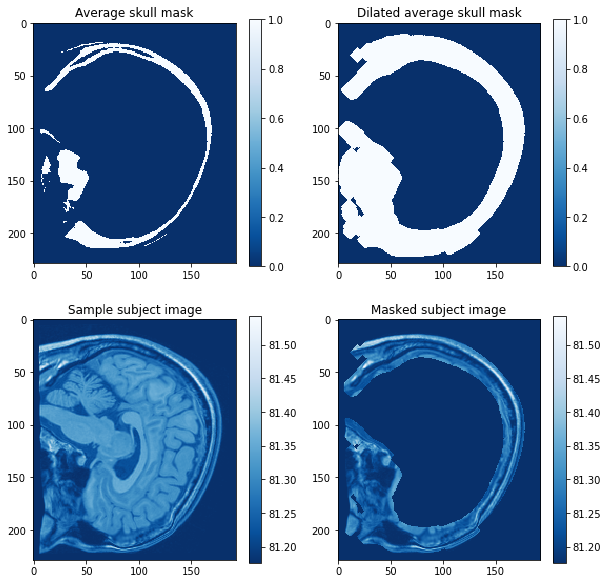

In [27]:
s = 100

skull_mask_slice = skull_mask[s,:,:]
skull_mask_dil_slice = skull_mask_dil[s,:,:]
subject_img_slice = subject_img[s,:,:]
masked_subject_img_slice = masked_subject_img[s,:,:]
vmin = np.min(subject_img_slice) 
vmax = np.max(subject_img_slice) 

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
seg_plot = plt.imshow(skull_mask_slice)
seg_plot.set_cmap("Blues_r")
plt.colorbar()
plt.title('Average skull mask')

plt.subplot(2,2,2)
seg_plot = plt.imshow(skull_mask_dil_slice)
seg_plot.set_cmap("Blues_r")
plt.colorbar()
plt.title('Dilated average skull mask')

plt.subplot(2,2,3)
seg_plot = plt.imshow(subject_img_slice)
seg_plot.set_cmap("Blues_r")
plt.colorbar()
plt.title('Sample subject image')

plt.subplot(2,2,4)
seg_plot = plt.imshow(masked_subject_img_slice,vmin=vmin,vmax=vmax)
seg_plot.set_cmap("Blues_r")
plt.colorbar()
plt.title('Masked subject image')

In [29]:
# Check patched data
skull_labels = []
for p in range(400):
    mr_patch= np.load(proj_dir + 'data/patches/p32/sub_05/{}.npy'.format(p))
    skull_labels.append(np.sum(mr_patch[:,:,:,1]))

Text(0,0.5,'patch count')

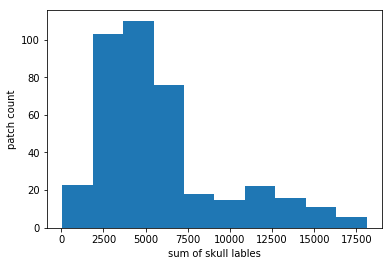

In [33]:
plt.hist(np.array(skull_labels).ravel(),bins=10);
plt.xlabel('sum of skull lables')
plt.ylabel('patch count')